In [20]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
from transformers import AutoModel, AutoModelForImageClassification, AutoImageProcessor, AutoConfig
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback, get_cosine_schedule_with_warmup
import torchaudio

from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

import random
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

SEED = 42

cuda


In [21]:
# train and test data paths
train_csv = 'data/2025/train.csv'
taxonomy_csv = 'data/2025/taxonomy.csv'

# Configuration for mel spectrogram
mel_spec_params = {
    "sample_rate": 32000,
    "n_mels": 128,
    "f_min": 20,
    "f_max": 16000,
    "n_fft": 1024,
    "hop_length": 500,
    "normalized": True,
    "center": True,
    "pad_mode": "constant",
    "norm": "slaney",
    "mel_scale": "slaney"
}
top_db = 80
train_duration = 10 * mel_spec_params["sample_rate"]  # 10 seconds

In [22]:
# dataset and mel conversion
def normalize_melspec(X, eps=1e-6):
    """Normalize mel spectrogram"""
    mean = X.mean((1, 2), keepdim=True)
    std = X.std((1, 2), keepdim=True)
    Xstd = (X - mean) / (std + eps)

    norm_min, norm_max = (
        Xstd.min(-1)[0].min(-1)[0],
        Xstd.max(-1)[0].max(-1)[0],
    )
    fix_ind = (norm_max - norm_min) > eps * torch.ones_like(
        (norm_max - norm_min)
    )
    V = torch.zeros_like(Xstd)
    if fix_ind.sum():
        V_fix = Xstd[fix_ind]
        norm_max_fix = norm_max[fix_ind, None, None]
        norm_min_fix = norm_min[fix_ind, None, None]
        V_fix = torch.max(
            torch.min(V_fix, norm_max_fix),
            norm_min_fix,
        )
        V_fix = (V_fix - norm_min_fix) / (norm_max_fix - norm_min_fix)
        V[fix_ind] = V_fix
    return V

class BirdTrainDataset(Dataset):
    def read_audio(self, path):
        """Read audio file (ogg format) and resample"""
        # Using torchaudio to read ogg files
        wav, org_sr = torchaudio.load(path, normalize=True)
        wav = torchaudio.functional.resample(
            wav, orig_freq=org_sr, new_freq=mel_spec_params["sample_rate"]
        )
            
        return wav

    def crop_audio(self, wav, duration_):
        """Crop or pad audio to specific duration"""
        if wav.size(-1) < duration_:
            # If audio is shorter than desired duration, loop it
            num_repeats = int(np.ceil(duration_ / wav.size(-1)))
            wav = torch.cat([wav] * num_repeats, dim=1)
        # Crop to exact duration
        wav = wav[:, :duration_]
        return wav

    def prepare_spec(self, path):
        """Create mel spectrogram from audio file"""
        # Read and crop audio
        wav = self.read_audio(path)
        wav = self.crop_audio(wav, train_duration)
        
        # Create mel spectrogram
        mel_spectrogram = self.mel_transform(wav)
        mel_spectrogram = self.db_transform(mel_spectrogram)
        mel_spectrogram = normalize_melspec(mel_spectrogram)
        
        # Scale to 0-255 range for image-like processing
        mel_spectrogram = mel_spectrogram * 255
        
        # Convert to 3-channel image format (RGB)
        mel_spectrogram = mel_spectrogram.expand(3, -1, -1).permute(1, 2, 0).numpy()

        return mel_spectrogram

    def __init__(self, data_df, taxonomy_df, transforms=None, data_path='data'):
        self.df = data_df

        # Map species id to label
        taxonomy = sorted(set(taxonomy_df['primary_label'].values))
        self.taxonomy = {species: i for i, species in enumerate(taxonomy)}
        self.num_classes = len(self.taxonomy)
        
        # Create mel spectrogram transformation objects
        self.mel_transform = torchaudio.transforms.MelSpectrogram(**mel_spec_params)
        self.db_transform = torchaudio.transforms.AmplitudeToDB(stype='power', top_db=top_db)

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Get the audio file path and label
        path = os.path.join('data/2025/train_audio', self.df.iloc[idx]['filename'])
        primary_label = self.df.iloc[idx]['primary_label']
        
        # Create spectrogram
        spec = self.prepare_spec(path)
        
        # Get the label index
        label_idx = self.taxonomy[primary_label]
        
        # Final formatting: Convert to [C, H, W] format
        spec = spec.transpose(2, 0, 1)

        # formatted for trainer
        return {
            "pixel_values": torch.tensor(spec, dtype=torch.float32),
            "labels": torch.tensor(label_idx, dtype=torch.long),
            "file_name": path,
        }

def get_datasets():
    full_df = pd.read_csv(train_csv)
    taxonomy_df = pd.read_csv(taxonomy_csv)

    # Split data into train and validation sets
    train_df, val_df = train_test_split(
      full_df, 
      test_size=0.3, 
      random_state=42, 
      stratify=full_df['primary_label']
    )

    train_ds = BirdTrainDataset(train_df, taxonomy_df)
    val_ds = BirdTrainDataset(val_df, taxonomy_df)
    return train_ds, val_ds

ds_train, ds_val = get_datasets()
print("train_loader", len(ds_train))
print("val_loader", len(ds_val))
print("num_classes", ds_train.num_classes)

train_loader 19994
val_loader 8570
num_classes 206


In [25]:
ds_train = BirdTrainDataset(pd.read_csv(train_csv), pd.read_csv(taxonomy_csv))

Target: 0
Shape of mel spectrogram: torch.Size([3, 128, 641])


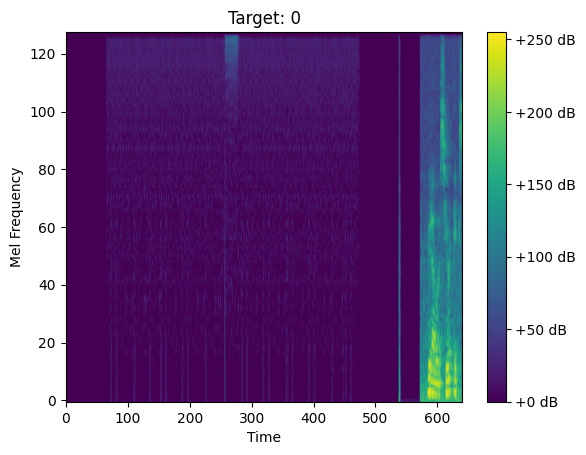

In [26]:
#res = ds_train[random.randint(0, len(ds_train)-1)]
res = ds_train[0]
spec = res['pixel_values']
target = res['labels']

print(f"Target: {target}")
print(f"Shape of mel spectrogram: {spec.shape}")

# Display the mel spectrogram
plt.imshow(spec[0], aspect='auto', origin='lower')
plt.title(f"Target: {target}")
plt.colorbar(format='%+2.0f dB')
plt.xlabel("Time")
plt.ylabel("Mel Frequency")
plt.show()

In [12]:
# Define metrics computation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)
    
    # Calculate F1 score (weighted for class imbalance)
    f1 = f1_score(labels, predictions, average="weighted")
    
    return {
        "accuracy": accuracy,
        "f1": f1
    }

In [13]:
# Effnet finetune setup
LR = 1e-5
NUM_EPOCHS = 30
BATCH_SIZE = 64
MODEL_NAME = "google/efficientnet-b2"
NUM_CLASSES = 206
DROPOUT_RATE = .3

config = AutoConfig.from_pretrained(MODEL_NAME)
config.num_labels = NUM_CLASSES  # Number of output classes
config.hidden_dropout_prob = DROPOUT_RATE  # Dropout for dense layers
config.attention_probs_dropout_prob = DROPOUT_RATE  # Only applicable if the model has attention layers (EfficientNet doesn't)

processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
model = AutoModelForImageClassification.from_pretrained(
    MODEL_NAME,
    config=config,
    ignore_mismatched_sizes=True
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results_effnet",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=1e-3,
    logging_dir="./logs",
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=1000,
    save_steps=1000,
    save_total_limit=2,
    learning_rate=LR,
    fp16=torch.cuda.is_available(),  # Enable mixed precision training if available
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    remove_unused_columns=False,
    warmup_steps=500,
    lr_scheduler_type="linear",
)

Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b2 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1408]) in the checkpoint and torch.Size([206, 1408]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([206]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Create and run trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1
1000,4.773400,4.752832,0.111552,0.062923
2000,3.679700,3.637358,0.263594,0.183235
3000,2.917400,2.949955,0.394282,0.315047
4000,2.536300,2.582830,0.460327,0.390689
5000,2.268700,2.350271,0.502334,0.441542
6000,2.078900,2.218458,0.527888,0.470189
7000,1.964600,2.091806,0.549942,0.497005
8000,1.889800,2.052410,0.561844,0.512131
9000,1.877600,2.040306,0.564177,0.513139


TrainOutput(global_step=9390, training_loss=2.806614832933972, metrics={'train_runtime': 13135.0589, 'train_samples_per_second': 45.666, 'train_steps_per_second': 0.715, 'total_flos': 7.079067534195671e+18, 'train_loss': 2.806614832933972, 'epoch': 30.0})